In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iris-segmentation/results/results/S1209R04.png
/kaggle/input/iris-segmentation/results/results/S1104L04.png
/kaggle/input/iris-segmentation/results/results/S1071R06.png
/kaggle/input/iris-segmentation/results/results/S1083L07.png
/kaggle/input/iris-segmentation/results/results/S1003R07.png
/kaggle/input/iris-segmentation/results/results/S1162R06.png
/... 
/kaggle/input/iris-segmentation/data_iris/data_iris/train/S1130R07.jpg
/kaggle/input/iris-segmentation/data_iris/data_iris/train/S1185L02.jpg
/kaggle/input/iris-segmentation/data_iris/data_iris/train/S1221R02.jpg
/kaggle/input/iris-segmentation/data_iris/data_iris/train/S1219R05.jpg
/kaggle/input/iris-segmentation/data_iris/data_iris/train/S1111L07.jpg
/kaggle/input/iris-segmentation/data_iris/data_iris/train/S1121L02.jpg
/kaggle/input/iris-segmentation/data_iris/data_iris/train/S1023R01.jpg
/kaggle/input/iris-segmentation/data_iris/data_iris/train/S1247R03.jpg
/kaggle/input/iris-segmentation/data_iris/data_iris/train/S1

In [2]:
!pip install torchmetrics
!pip install segmentation_models_pytorch
!pip install albumentations
!pip install torchsummary


In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchmetrics
from torchmetrics import Dice, JaccardIndex
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2 # np.array -> torch.tensor
import os
from tqdm import tqdm
from glob import glob

In [4]:
print(A.__version__)

1.4.0


In [5]:
class IrisDataset(Dataset):
    def __init__(self, root_dir, ROI_input, results, transform=None):
        self.root_dir = root_dir
        self.ROI_input = ROI_input
        self.results = results
        self.transform = transform
        self.img_path_lst = []
        # Lấy danh sách các tệp hình ảnh từ thư mục ROI_input
        img_files = [f for f in os.listdir(self.ROI_input) if f.endswith(".jpg")]
        for filename in img_files:
            self.img_path_lst.append(filename)  # Thêm tên file vào danh sách

    def __len__(self):
        return len(self.img_path_lst)

    def __getitem__(self, idx):
        # Xây dựng đường dẫn đầy đủ đến hình ảnh và mặt nạ
        image_path = os.path.join(self.ROI_input, self.img_path_lst[idx])
        mask_path = os.path.join(self.results, self.img_path_lst[idx].replace(".jpg", ".png"))

        # Đọc hình ảnh và mặt nạ từ đường dẫn
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if mask is None:  # Kiểm tra xem mask có bị None hay không
          mask = np.zeros_like(image[..., 0])  # Tạo mặt nạ trống
        else:
          mask = mask.astype('uint8')  # Chuyển đổi kiểu dữ liệu sang uint8

        # Chuyển các giá trị mặt nạ 255 thành 1
        mask[mask >= 200] = 1

        # Áp dụng biến đổi nếu có
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            transformed_image = transformed['image']
            transformed_mask = transformed['mask']
            return transformed_image, transformed_mask
        else:
            return image, mask

In [6]:
trainsize = 384

train_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Blur(),
    A.Sharpen(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

test_trainsform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(), # numpy.array -> torch.tensor (B, 3, H, W)
])

In [7]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [8]:
 train_dataset = IrisDataset("/kaggle/input/iris-segmentation", "/kaggle/input/iris-segmentation/data_iris/data_iris/train", "/kaggle/input/iris-segmentation/results/results", train_transform)
 test_dataset =  IrisDataset("/kaggle/input/iris-segmentation", "/kaggle/input/iris-segmentation/data_iris/data_iris/test", "/kaggle/input/iris-segmentation/results/results", test_trainsform)
# image, mask = train_dataset.__getitem__(10)
# plt.subplot(1, 2, 1)
# plt.imshow(unorm(image).permute(1, 2, 0))
# plt.subplot(1, 2, 2)
# plt.imshow(mask)
# plt.show

In [9]:
#model UNet
def unet_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1),
        nn.ReLU()
    )

class UNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes
        self.downsample = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear")
        self.block_down1 = unet_block(3, 64)
        self.block_down2 = unet_block(64, 128)
        self.block_down3 = unet_block(128, 256)
        self.block_down4 = unet_block(256, 512)
        self.block_neck = unet_block(512, 1024)
        self.block_up1 = unet_block(1024+512, 512)
        self.block_up2 = unet_block(256+512, 256)
        self.block_up3 = unet_block(128+256, 128)
        self.block_up4 = unet_block(128+64, 64)
        self.conv_cls = nn.Conv2d(64, self.n_classes, 1) # -> (B, n_class, H, W)

    def forward(self, x):
        # (B, C, H, W)
        x1 = self.block_down1(x)
        x = self.downsample(x1)
        x2 = self.block_down2(x)
        x = self.downsample(x2)
        x3 = self.block_down3(x)
        x = self.downsample(x3)
        x4 = self.block_down4(x)
        x = self.downsample(x4)

        x = self.block_neck(x)

        x = torch.cat([x4, self.upsample(x)], dim=1)
        x = self.block_up1(x)
        x = torch.cat([x3, self.upsample(x)], dim=1)
        x = self.block_up2(x)
        x = torch.cat([x2, self.upsample(x)], dim=1)
        x = self.block_up3(x)
        x = torch.cat([x1, self.upsample(x)], dim=1)
        x = self.block_up4(x)

        x = self.conv_cls(x)
        return x

# model = UNet(1)
# x = torch.rand(4, 3, trainsize, trainsize)
# print("Input shape =", x.shape)
# y = model(x).squeeze()
# print("Output shape = ", y.shape)
# # y true (4, 384, 384)
# # y hat.squeeze() (4, 1, 384, 384) -> (4, 384, 384)

In [10]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [11]:
#accuracy fn
def accuracy_function(preds, targets):
    preds_flat = preds.flatten()
    targets_flat = targets.flatten()
    acc = torch.sum(preds_flat == targets_flat)
    return acc/targets_flat.shape[0]

In [12]:
from torchsummary import summary

#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#load data
batch_size = 8
n_workers = os.cpu_count()
print("num_workers =", n_workers)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=n_workers)

#model
model = UNet(1).to(device)
summary(model, input_size=(3, 384, 384))

#loss
criterion = nn.BCEWithLogitsLoss()

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
n_eps = 100

#metrics
dice_fn = torchmetrics.Dice(num_classes=2, average="macro").to(device)
iou_fn = torchmetrics.JaccardIndex(num_classes=2, task="binary", average="macro").to(device)

#meter
acc_meter = AverageMeter()
train_loss_meter = AverageMeter()
dice_meter = AverageMeter()
iou_meter = AverageMeter()

num_workers = 4
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 384, 384]           1,792
              ReLU-2         [-1, 64, 384, 384]               0
            Conv2d-3         [-1, 64, 384, 384]          36,928
              ReLU-4         [-1, 64, 384, 384]               0
         MaxPool2d-5         [-1, 64, 192, 192]               0
            Conv2d-6        [-1, 128, 192, 192]          73,856
              ReLU-7        [-1, 128, 192, 192]               0
            Conv2d-8        [-1, 128, 192, 192]         147,584
              ReLU-9        [-1, 128, 192, 192]               0
        MaxPool2d-10          [-1, 128, 96, 96]               0
           Conv2d-11          [-1, 256, 96, 96]         295,168
             ReLU-12          [-1, 256, 96, 96]               0
           Conv2d-13          [-1, 256, 96, 96]         590,080
             ReLU-14   

In [13]:
best_iou = 0.0
best_dice = 0.0
best_epoch = 0

# Kiểm tra xem có nhiều hơn một GPU hay không và bọc mô hình trong DataParallel nếu có
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

model = model.to(device)

for ep in range(1, 1+n_eps):
    acc_meter.reset()
    train_loss_meter.reset()
    dice_meter.reset()
    iou_meter.reset()
    model.train()

    for batch_id, (x, y) in enumerate(tqdm(trainloader), start=1):
        optimizer.zero_grad()
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).float()
        y_hat = model(x)
        y_hat = y_hat.squeeze()  # -> logit (-vc, +vc)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_hat_mask = y_hat.sigmoid().round().long()  # -> mask (0, 1)
            dice_score = dice_fn(y_hat_mask, y.long())
            iou_score = iou_fn(y_hat_mask, y.long())
            accuracy = accuracy_function(y_hat_mask, y.long())

            train_loss_meter.update(loss.item(), n)
            iou_meter.update(iou_score.item(), n)
            dice_meter.update(dice_score.item(), n)
            acc_meter.update(accuracy.item(), n)

    print(f"EP {ep}, train loss = {train_loss_meter.avg}, accuracy = {acc_meter.avg}, IoU = {iou_meter.avg}, dice = {dice_meter.avg}")

    # Kiểm tra xem epoch hiện tại có chỉ số IoU và Dice tốt nhất không
    if iou_meter.avg > best_iou or dice_meter.avg > best_dice:
        best_iou = max(iou_meter.avg, best_iou)
        best_dice = max(dice_meter.avg, best_dice)
        best_epoch = ep
        # Lưu mô hình nếu nó là tốt nhất cho đến thời điểm hiện tại
        model_to_save = model.module if isinstance(model, nn.DataParallel) else model
        torch.save(model_to_save.state_dict(), f"best_model_epoch_{best_epoch}.pth")
        print(f"Saved new best model at epoch {ep} with IoU: {best_iou}, Dice: {best_dice}")

print(f"Best model was saved at epoch {best_epoch} with IoU: {best_iou}, Dice: {best_dice}")

100%|██████████| 264/264 [02:20<00:00,  1.88it/s]


EP 1, train loss = 0.31378611537718004, accuracy = 0.8465750559005158, IoU = 0.49606915033511656, dice = 0.7355121061969301
Saved new best model at epoch 1 with IoU: 0.49606915033511656, Dice: 0.7355121061969301


100%|██████████| 264/264 [02:20<00:00,  1.89it/s]


EP 2, train loss = 0.08309258372863963, accuracy = 0.9683011846026615, IoU = 0.893272034696655, dice = 0.9606524117757519
Saved new best model at epoch 2 with IoU: 0.893272034696655, Dice: 0.9606524117757519


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 3, train loss = 0.05690893050163023, accuracy = 0.9783321676715728, IoU = 0.9255573057359264, dice = 0.9730995947767254
Saved new best model at epoch 3 with IoU: 0.9255573057359264, Dice: 0.9730995947767254


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 4, train loss = 0.05111463515678212, accuracy = 0.9802701036663164, IoU = 0.9320317880026077, dice = 0.9755184661731322
Saved new best model at epoch 4 with IoU: 0.9320317880026077, Dice: 0.9755184661731322


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 5, train loss = 0.048683407707617, accuracy = 0.9811139343133235, IoU = 0.9348203111192533, dice = 0.9765599298748617
Saved new best model at epoch 5 with IoU: 0.9348203111192533, Dice: 0.9765599298748617


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 6, train loss = 0.04684969453420313, accuracy = 0.9818364109214841, IoU = 0.9371956810779318, dice = 0.9774472019025452
Saved new best model at epoch 6 with IoU: 0.9371956810779318, Dice: 0.9774472019025452


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 7, train loss = 0.044469491771265045, accuracy = 0.9828285781889305, IoU = 0.9405511381277776, dice = 0.9786906476491316
Saved new best model at epoch 7 with IoU: 0.9405511381277776, Dice: 0.9786906476491316


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 8, train loss = 0.044081082889205814, accuracy = 0.983175559785832, IoU = 0.9416767364434997, dice = 0.9791036570547201
Saved new best model at epoch 8 with IoU: 0.9416767364434997, Dice: 0.9791036570547201


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 88, train loss = 0.009730987581274202, accuracy = 0.9957623456868094, IoU = 0.9849786252857838, dice = 0.9947422456696092
Saved new best model at epoch 88 with IoU: 0.9849786252857838, Dice: 0.9947422456696092


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 89, train loss = 0.009619151747500988, accuracy = 0.9958093730729264, IoU = 0.9851433587255243, dice = 0.9948004463818313
Saved new best model at epoch 89 with IoU: 0.9851433587255243, Dice: 0.9948004463818313


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 90, train loss = 0.009473201175497763, accuracy = 0.9958652611927923, IoU = 0.9853389411316424, dice = 0.994869237832824
Saved new best model at epoch 90 with IoU: 0.9853389411316424, Dice: 0.994869237832824


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 91, train loss = 0.009406468951173367, accuracy = 0.9959228741149975, IoU = 0.9855486897635053, dice = 0.9949419518801926
Saved new best model at epoch 91 with IoU: 0.9855486897635053, Dice: 0.9949419518801926


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 92, train loss = 0.009932438646791329, accuracy = 0.9956831915102602, IoU = 0.9847041020130975, dice = 0.994644771603977


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 93, train loss = 0.00967693187126738, accuracy = 0.9958000135602716, IoU = 0.9851147844624022, dice = 0.9947893810679383


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 94, train loss = 0.009048932152437983, accuracy = 0.9960580179768224, IoU = 0.9860307904529391, dice = 0.9951116785378791
Saved new best model at epoch 94 with IoU: 0.9860307904529391, Dice: 0.9951116785378791


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 95, train loss = 0.008896145625022263, accuracy = 0.9961144250077134, IoU = 0.9862303067656124, dice = 0.9951820037622832
Saved new best model at epoch 95 with IoU: 0.9862303067656124, Dice: 0.9951820037622832


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 96, train loss = 0.008829650789873933, accuracy = 0.9961441159248352, IoU = 0.9863282250950866, dice = 0.9952171595318268
Saved new best model at epoch 96 with IoU: 0.9863282250950866, Dice: 0.9952171595318268


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 97, train loss = 0.0087931502585704, accuracy = 0.9961627530644469, IoU = 0.9863868373847324, dice = 0.9952384492477837
Saved new best model at epoch 97 with IoU: 0.9863868373847324, Dice: 0.9952384492477837


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 98, train loss = 0.008972276770907403, accuracy = 0.9960896214452595, IoU = 0.9861349301727266, dice = 0.9951493427920839


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 99, train loss = 0.008751248430100179, accuracy = 0.9961926792332977, IoU = 0.986496786125697, dice = 0.9952768894933886
Saved new best model at epoch 99 with IoU: 0.986496786125697, Dice: 0.9952768894933886


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 100, train loss = 0.00866670610711855, accuracy = 0.9962111057773713, IoU = 0.9865616597305892, dice = 0.995299623406137
Saved new best model at epoch 100 with IoU: 0.9865616597305892, Dice: 0.995299623406137
Best model was saved at epoch 100 with IoU: 0.9865616597305892, Dice: 0.995299623406137


In [14]:
model.eval()
test_iou_meter = AverageMeter()
test_dice_meter = AverageMeter()
with torch.no_grad():
    for batch_id, (x, y) in enumerate(tqdm(testloader), start=1):
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).float()
        y_hat = model(x)
        y_hat = y_hat.squeeze()
        y_hat_mask = y_hat.sigmoid().round().long()
        dice_score = dice_fn(y_hat_mask, y.long())
        iou_score = iou_fn(y_hat_mask, y.long())
        test_dice_meter.update(dice_score.item(), n)
        test_iou_meter.update(iou_score.item(), n)
print("TEST: IoU = {}, dice = {}".format(test_iou_meter.avg, test_dice_meter.avg))

100%|██████████| 50/50 [00:09<00:00,  5.13it/s]

TEST: IoU = 0.9530380771129946, dice = 0.9833286182789863


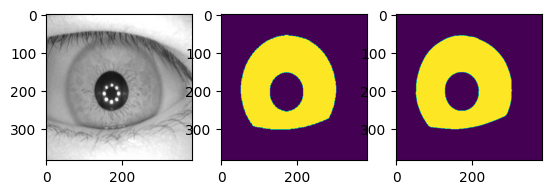

In [15]:
import random

model.eval()
idx = random.randint(0, 100)
with torch.no_grad():
    x, y = test_dataset[idx]
    # print(x.shape, y.shape) (C, H, W) -> (1, C, H, W) -> model
    x = x.to(device).float().unsqueeze(0)
    y_hat = model(x).squeeze() #(1, 1, H, W) -> (H, W)
    y_hat_mask = y_hat.sigmoid().round().long()
    # x, y, y_hat_mask
    plt.subplot(1, 3, 1)
    plt.imshow(unorm(x.squeeze().cpu()).permute(1, 2, 0)) # x (GPU) -> x(CPU)
    plt.subplot(1, 3, 2)
    plt.imshow(y)
    plt.subplot(1, 3, 3)
    plt.imshow(y_hat_mask.cpu())